In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pycocotools

In [2]:
import zipfile
import os

zip_file_path = '/content/drive/MyDrive/OSCD.zip'
dataset_folder = '/content/drive/MyDrive/OSCD/'

if len(os.listdir(dataset_folder)) == 0:
  with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
      zip_ref.extractall(dataset_folder)

  print(f"Unzipped to: {dataset_folder}")

In [4]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

train_folder = os.path.join(dataset_folder, 'coco_carton/oneclass_carton/images/train2017')
val_folder = os.path.join(dataset_folder, 'coco_carton/oneclass_carton/images/val2017')
train_annotation = os.path.join(dataset_folder, 'coco_carton/oneclass_carton/annotations/instances_train2017.json')
val_annotation = os.path.join(dataset_folder, 'coco_carton/oneclass_carton/annotations/instances_val2017.json')

In [114]:
import torch
from torchvision.datasets import CocoDetection
import torchvision.transforms as T
from PIL import Image
from torchvision.tv_tensors import Mask
from torchvision.transforms.functional import to_tensor
from skimage.draw import polygon as sk_polygon

class OSCDDataset(CocoDetection):
    def __init__(self, img_folder, ann_file):
        super().__init__(img_folder, ann_file, transforms=None)

    def __getitem__(self, idx):
        img, anns = super().__getitem__(idx)

        labels = []
        areas = []
        iscrowd = []
        masks = []

        for ann in anns:
            labels.append(ann['category_id'])
            areas.append(ann['area'])
            iscrowd.append(ann['iscrowd'])
            mask = self.get_mask(ann['segmentation'], img.size[1], img.size[0])
            masks.append(mask)


        labels = torch.tensor(labels, dtype=torch.int64)
        areas = torch.tensor(areas, dtype=torch.float32)
        iscrowd = torch.tensor(iscrowd, dtype=torch.uint8)

        masks = torch.stack([m.unsqueeze(0) for m in masks])

        target = {
            "labels": labels,
            "image_id": torch.tensor([idx]),
            "area": areas,
            "iscrowd": iscrowd,
            "masks": Mask(masks)
        }
        img = to_tensor(img)
        return img, target

    def get_mask(self, segmentation, height, width):
        mask = torch.zeros((height, width), dtype=torch.uint8)
        poly_x = segmentation[0][::2]
        poly_y = segmentation[0][1::2]
        rr, cc = sk_polygon(poly_y, poly_x, shape=(height, width))
        mask[rr, cc] = 1
        return mask


In [115]:
train_dataset = OSCDDataset(train_folder, train_annotation)
val_dataset = OSCDDataset(val_folder, val_annotation)

loading annotations into memory...
Done (t=1.62s)
creating index...
index created!
loading annotations into memory...
Done (t=0.15s)
creating index...
index created!


In [123]:
def collate_fn(batch):
    images, targets = list(zip(*batch))
    return images, targets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

In [124]:
train_data = next(iter(train_loader))
val_data = next(iter(val_loader))

In [125]:
import matplotlib.pyplot as plt
import numpy as np

def show_image_with_masks(img, target):
  img_np = img.permute(1, 2, 0).cpu().numpy()
  plt.figure(figsize=(12,12))
  plt.imshow(img_np)
  for mask in target['masks']:
    mask_np = mask.permute(1, 2, 0).cpu().numpy()
    mask_np = np.ma.masked_where(mask_np == 0, mask_np)
    plt.imshow(mask_np, cmap='jet', alpha=0.5)
  plt.axis('off')
  plt.show()

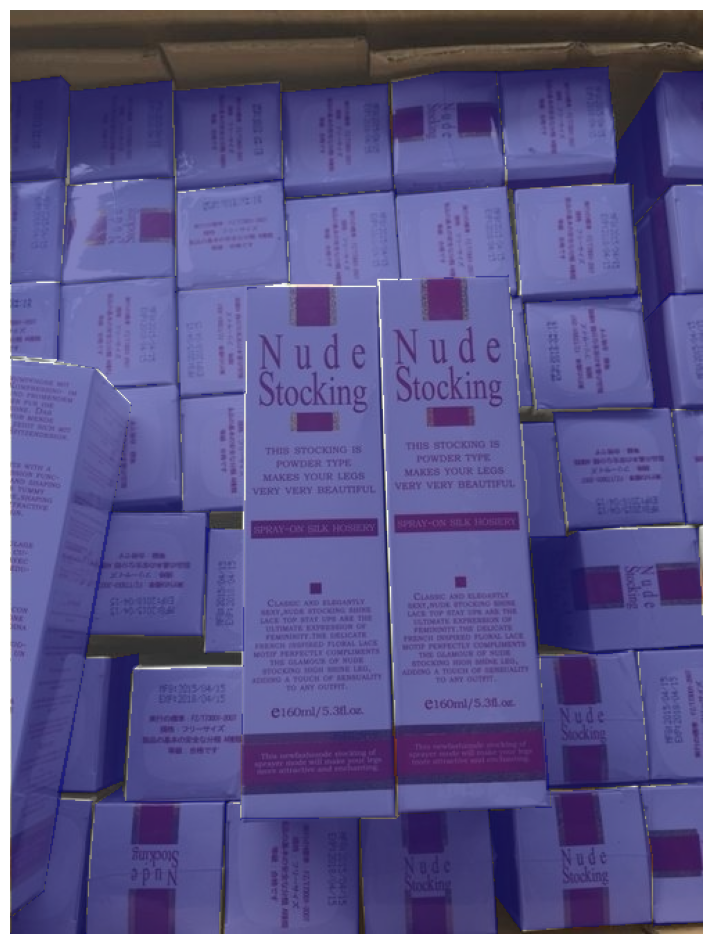

In [129]:
img = train_data[0][10]
target = train_data[1][10]
show_image_with_masks(img, target)

In [40]:
print(target['labels'])

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
